In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp

int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

file_dir = 'E:\\Ising_model_results_daai'

training_index_start = 0
training_index_end = 670

In [2]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [3]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [4]:
def print_stats_too_big(name:str, values:torch.Tensor):
    values, _ = torch.sort( values.flatten() )
    num_values = values.numel()
    min_val = values[0]
    low_end = (num_values * 25)//1000
    low_val = values[low_end]
    print(f'lower quantile {low_end}, -1 and +1', values[low_end-1], values[low_end], values[low_end+1] )
    half_index = num_values//2
    print(f'half way point {half_index}, -1 and +1', values[half_index-1], values[half_index], values[half_index+1] )
    if (num_values % 2) == 0:
        med_val = (values[half_index] + values[half_index+1])/2
    else:
        med_val = values[half_index+1]
    high_end = (num_values * 975)//1000
    high_val = values[high_end]
    print(f'upper quantile {high_end}, -1 and +1', values[high_end-1], values[high_end], values[high_end+1] )
    max_val = values[-1]
    print(f'The distribution of {name} values has median {med_val:.3g} with 95% CI [{low_val:.3g}, {high_val:.3g}] and range [{min_val:.3g}, {max_val:.3g}].')

In [5]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [6]:
def make_scatter(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.scatter(  depytorch( xvalues.flatten() ), depytorch( yvalues.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [7]:
def make_errorbar_two_sides(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, y_bounds=None, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    y_middle = yvalues[:,1]
    y_low = y_middle - yvalues[:,0]
    y_high = yvalues[:,2] - y_middle
    y_err = torch.stack( (y_low,y_high), dim=0 )
    axs.errorbar(  x=depytorch(xvalues), y=depytorch(y_middle), yerr=depytorch(y_err), color='red', ecolor='blue'  )
    # axs.plot(x_flat, y_flat, color='red', label='mean', linewidth=10, fillstyle='full')
    if type(y_bounds) != type(None):
        axs.set_ylim(y_bounds)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.legend()
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [8]:
def show_square(values:torch.Tensor, width:int=10, height:int=10):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(width, height) )
    cbax = axs.imshow( depytorch(values) )
    fig.colorbar(cbax, shrink=0.8)

In [9]:
# data_file_name_part = 'all_mean_std_1'
# model_file_name_part = f'{data_file_name_part}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_38000'
data_file_name_part = 'all_mean_std_0'
model_file_name_part = f'{data_file_name_part}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000'
mean_state_file = os.path.join(file_dir, f'mean_state_{data_file_name_part}.pt')
mean_state_product_file = os.path.join(file_dir, f'mean_state_product_{data_file_name_part}.pt')
model_file = os.path.join(file_dir, f'ising_model_light_{model_file_name_part}.pt')

In [10]:
def load_model():
    model = torch.load(model_file)
    print(f'loaded {model_file}')
    print( 'beta size', model.beta.size() )
    print( 'h size', model.h.size() )
    print( 'J size', model.J.size() )
    beta = model.beta[:,training_index_start:training_index_end]
    print( 'beta with just training subjects size', beta.size() )
    h = model.h[:,training_index_start:training_index_end,:]
    print( 'h with just training subjects size', h.size() )
    J = model.J[:,training_index_start:training_index_end,:,:]
    print( 'J with just training subjects size', J.size() )
    return beta, h, J

In [11]:
def print_correlation(a_name:str, a:torch.Tensor, b_name:str, b:torch.Tensor):
    correlation = torch.corrcoef(   torch.stack(  ( a.flatten(), b.flatten() ), dim=0  )   )[0,1]
    print(f'correlation between {a_name} and {b_name} is {correlation:.3g}')
    return correlation

In [12]:
mean_state = torch.load(mean_state_file)[:,training_index_start:training_index_end,:]
print( 'mean_state size', mean_state.size() )

mean_state size torch.Size([4, 670, 360])


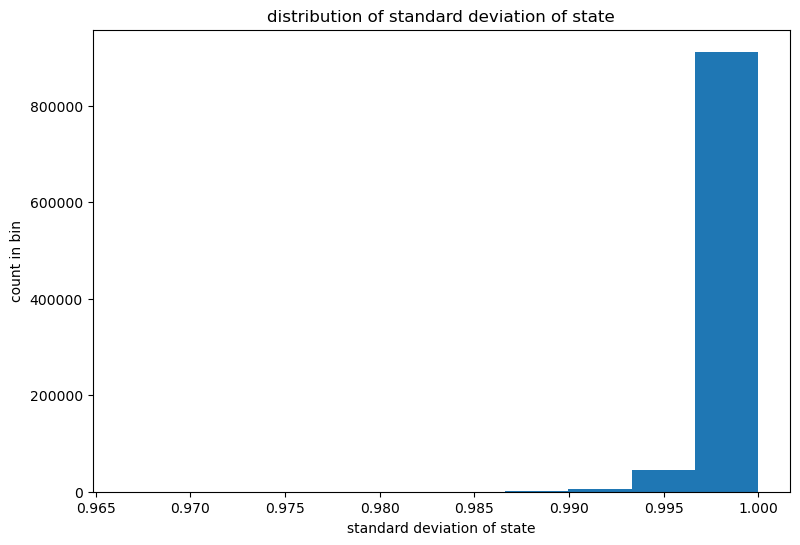

The distribution of standard deviation of state values has median 1 with 95% CI [0.995, 1] and range [0.966, 1].


In [13]:
std_state = torch.sqrt( 1 - mean_state * mean_state )
make_histogram(name='standard deviation of state', values=std_state)
print_stats(name='standard deviation of state', values=std_state)

In [14]:
def load_beta_h():
    beta, h, _ = load_model()
    return beta, h
beta, h = load_beta_h()

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


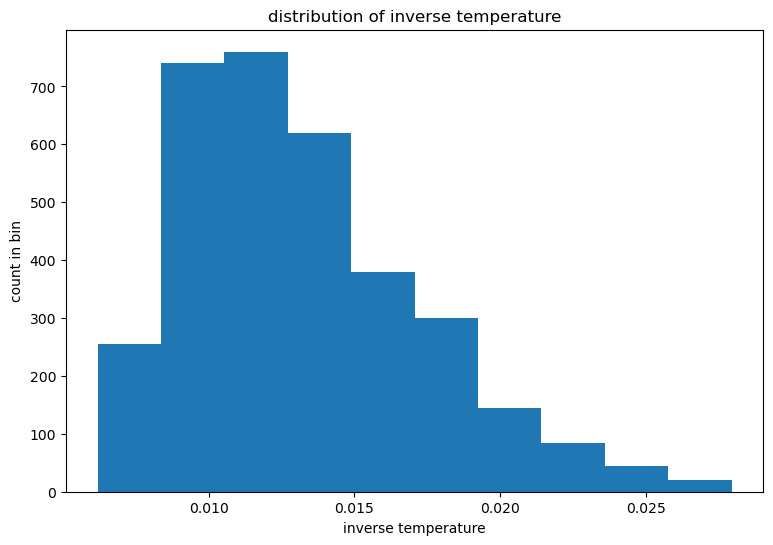

The distribution of inverse temperature values has median 0.0124 with 95% CI [0.00742, 0.023] and range [0.00619, 0.0279].


In [15]:
make_histogram(name='inverse temperature', values=beta)
print_stats(name='inverse temperature', values=beta)

In [16]:
# We trained each model on all 4 scans of a subject put together, so mean them and repeat for each subject.
num_reps = h.size(dim=0)
mean_state = mean_state.mean(dim=0,keepdim=True).repeat( (num_reps,1,1) )

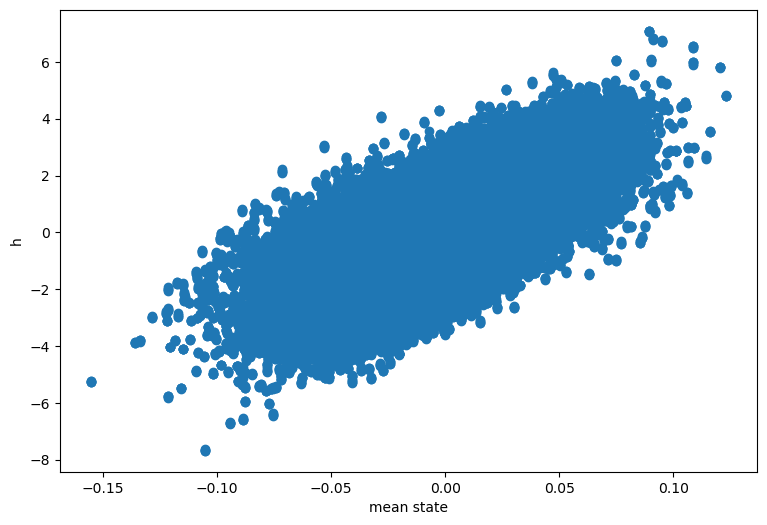

correlation between mean state and h is 0.763


tensor(0.7631, device='cuda:0')

In [17]:
make_scatter('mean state', mean_state, 'h', h)
print_correlation('mean state', mean_state, 'h', h)

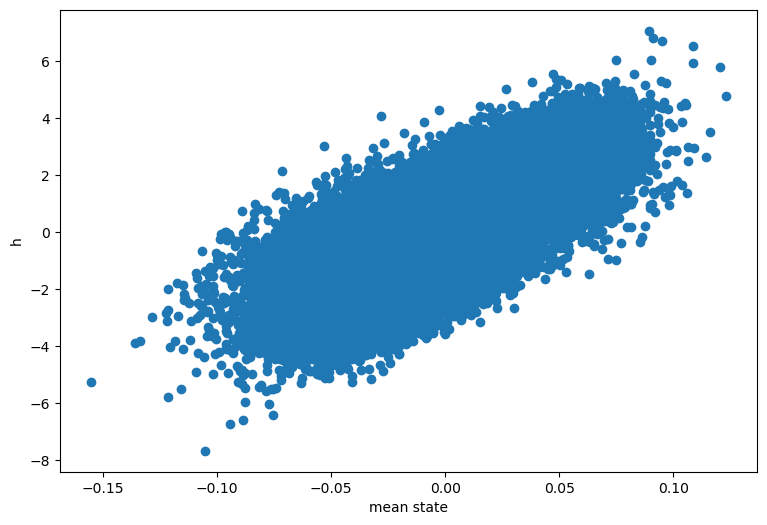

averaged over replicas
correlation between mean state and h is 0.763


In [18]:
def plot_and_print_mean():
    mean_mean_state = mean_state.mean(dim=0)
    mean_h = h.mean(dim=0)
    make_scatter('mean state', mean_mean_state, 'h', mean_h)
    print('averaged over replicas')
    print_correlation('mean state', mean_mean_state, 'h', mean_h)
plot_and_print_mean()

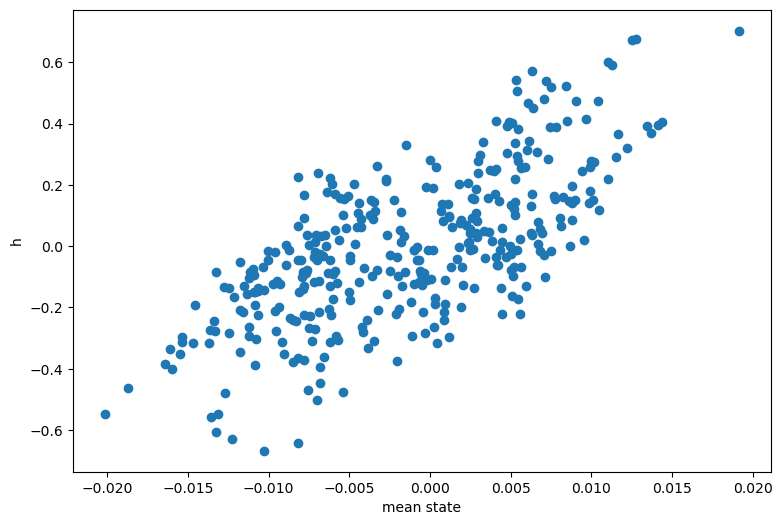

averaged over subjects
correlation between mean state and h is 0.696


In [19]:
def plot_and_print_group():
    group_mean_state = mean_state.mean( dim=(0,1) )
    group_h = h.mean( dim=(0,1) )
    make_scatter('mean state', group_mean_state, 'h', group_h)
    print('averaged over subjects')
    print_correlation('mean state', group_mean_state, 'h', group_h)
plot_and_print_group()

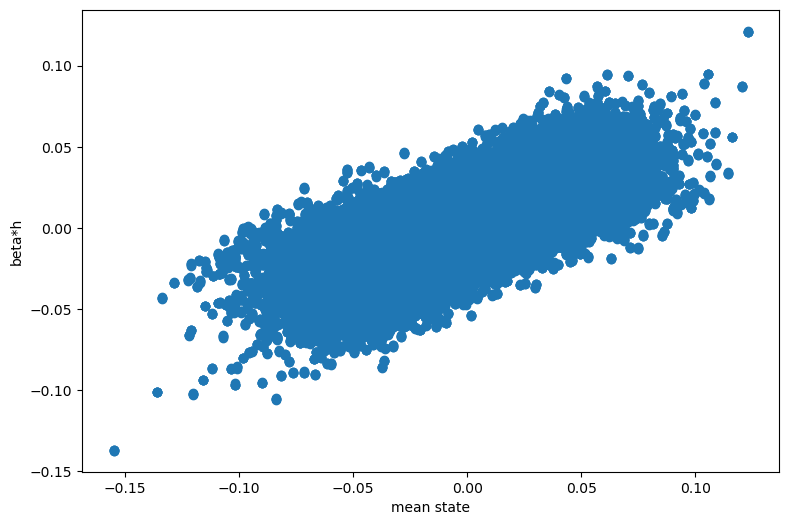

correlation between mean state and beta*h is 0.752


tensor(0.7520, device='cuda:0')

In [20]:
beta_h = beta.unsqueeze(dim=-1) * h
make_scatter('mean state', mean_state, 'beta*h', beta_h)
print_correlation('mean state', mean_state, 'beta*h', beta_h)

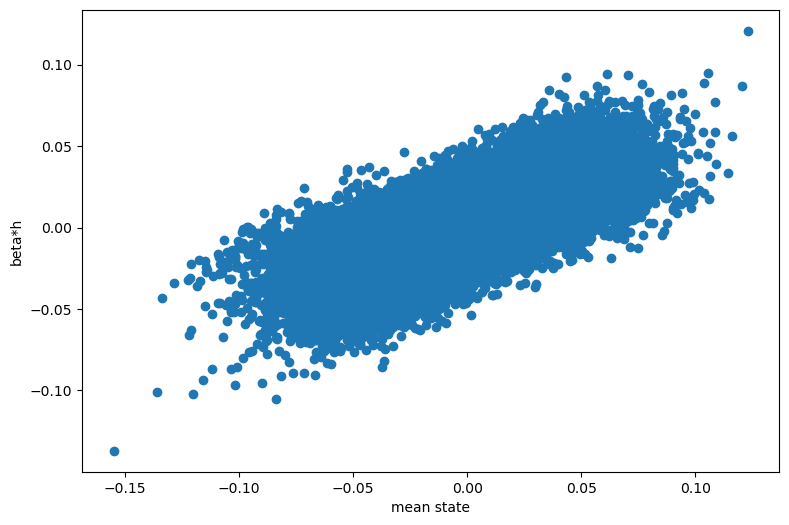

averaged over replicas
correlation between mean state and beta*h is 0.752


In [21]:
def plot_and_print_mean_beta():
    mean_mean_state = mean_state.mean(dim=0)
    mean_beta_h = beta_h.mean(dim=0)
    make_scatter('mean state', mean_mean_state, 'beta*h', mean_beta_h)
    print('averaged over replicas')
    print_correlation('mean state', mean_mean_state, 'beta*h', mean_beta_h)
plot_and_print_mean_beta()

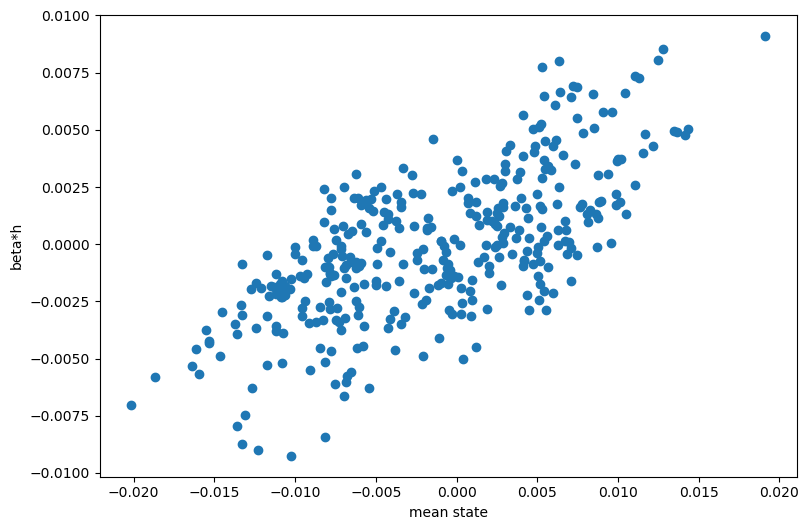

averaged over subjects
correlation between mean state and beta*h is 0.689


In [22]:
def plot_and_print_group_beta():
    group_mean_state = mean_state.mean( dim=(0,1) )
    group_beta_h = beta_h.mean( dim=(0,1) )
    make_scatter('mean state', group_mean_state, 'beta*h', group_beta_h)
    print('averaged over subjects')
    print_correlation('mean state', group_mean_state, 'beta*h', group_beta_h)
plot_and_print_group_beta()

In [12]:
def load_J():
    _, _, J = load_model()
    return J
J = load_J()

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [13]:
# We trained each model on all 4 scans of a subject put together, so mean them and repeat for each subject.
num_reps = J.size(dim=0)
mean_state_product = torch.load(mean_state_product_file)[:,training_index_start:training_index_end,:,:].mean(dim=0,keepdim=True).repeat( (num_reps,1,1,1) )
print( 'mean_state_porduct size', mean_state_product.size() )

NameError: name 'J' is not defined

In [ ]:
triu_indices = torch.triu_indices( row=mean_state_product.size(dim=-2), col=mean_state_product.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
mean_state_product_triu = mean_state_product[:,:,triu_rows,triu_cols]
J_triu = J[:,:,triu_rows,triu_cols]

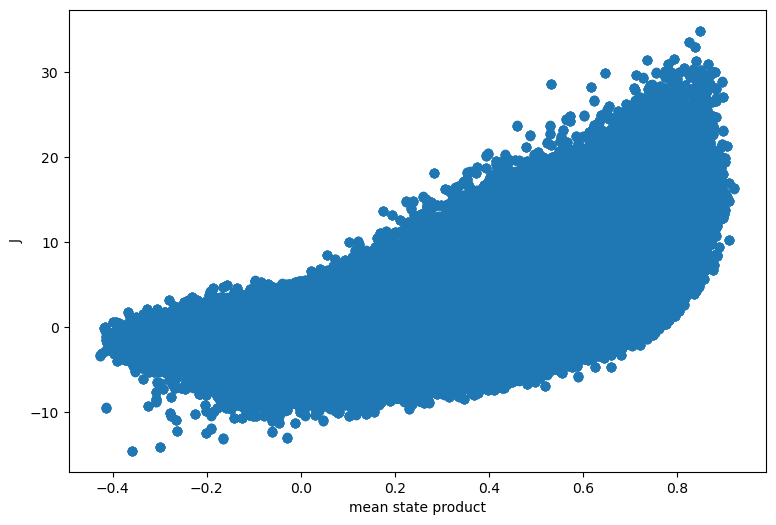

correlation between mean state product and J is 0.463


tensor(0.4629, device='cuda:0')

In [15]:
make_scatter('mean state product', mean_state_product_triu, 'J', J_triu)
print_correlation('mean state product', mean_state_product_triu, 'J', J_triu)

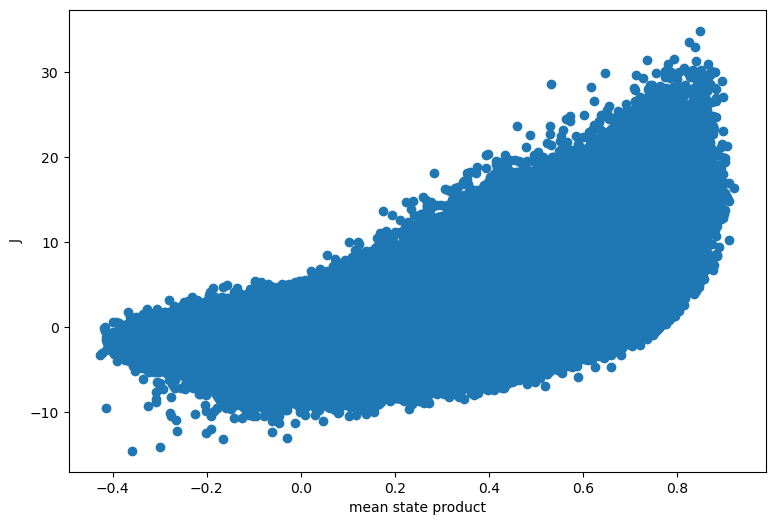

averaged over replicas
correlation between mean state product and J is 0.463


In [16]:
def plot_and_print_mean_J():
    mean_mean_state_product_triu = mean_state_product_triu.mean(dim=0)
    mean_J_triu = J_triu.mean(dim=0)
    make_scatter('mean state product', mean_mean_state_product_triu, 'J', mean_J_triu)
    print('averaged over replicas')
    print_correlation('mean state product', mean_mean_state_product_triu, 'J', mean_J_triu)
plot_and_print_mean_J()

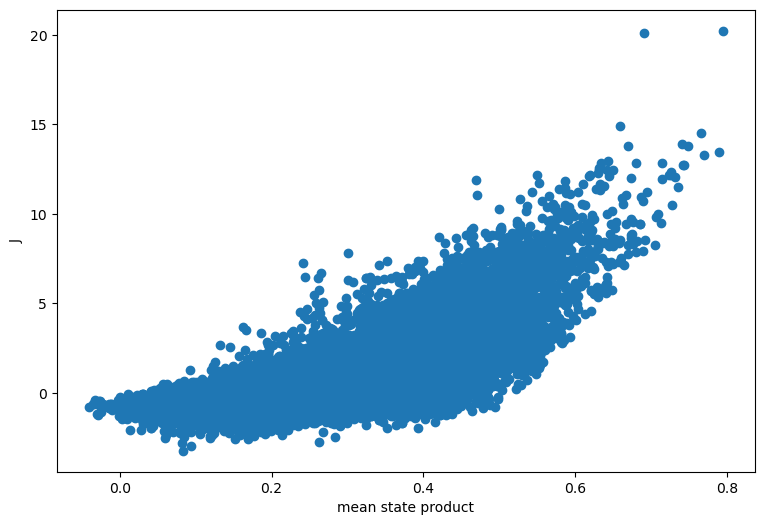

averaged over subjects
correlation between mean state product and J is 0.651


In [17]:
def plot_and_print_group_J():
    group_mean_state_product_triu = mean_state_product_triu.mean( dim=(0,1) )
    group_J_triu = J_triu.mean( dim=(0,1) )
    make_scatter('mean state product', group_mean_state_product_triu, 'J', group_J_triu)
    print('averaged over subjects')
    print_correlation('mean state product', group_mean_state_product_triu, 'J', group_J_triu)
plot_and_print_group_J()

In [12]:
def load_beta_J():
    beta, _, J = load_model()
    return beta.unsqueeze(dim=-1).unsqueeze(dim=-1) * J
beta_J = load_beta_J()

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [13]:
# We trained each model on all 4 scans of a subject put together, so mean them and repeat for each subject.
num_reps = beta_J.size(dim=0)
mean_state_product = torch.load(mean_state_product_file)[:,training_index_start:training_index_end,:,:].mean(dim=0,keepdim=True).repeat( (num_reps,1,1,1) )
print( 'mean_state_porduct size', mean_state_product.size() )

mean_state_porduct size torch.Size([5, 670, 360, 360])


In [15]:
triu_indices = torch.triu_indices( row=mean_state_product.size(dim=-2), col=mean_state_product.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
mean_state_product_triu = mean_state_product[:,:,triu_rows,triu_cols]
beta_J_triu = beta_J[:,:,triu_rows,triu_cols]

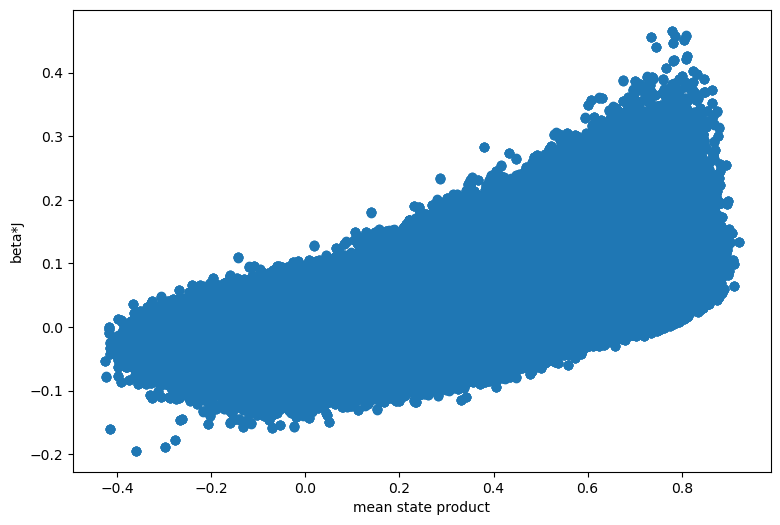

correlation between mean state product and beta*J is 0.438


tensor(0.4380, device='cuda:0')

In [16]:
make_scatter('mean state product', mean_state_product_triu, 'beta*J', beta_J_triu)
print_correlation('mean state product', mean_state_product_triu, 'beta*J', beta_J_triu)

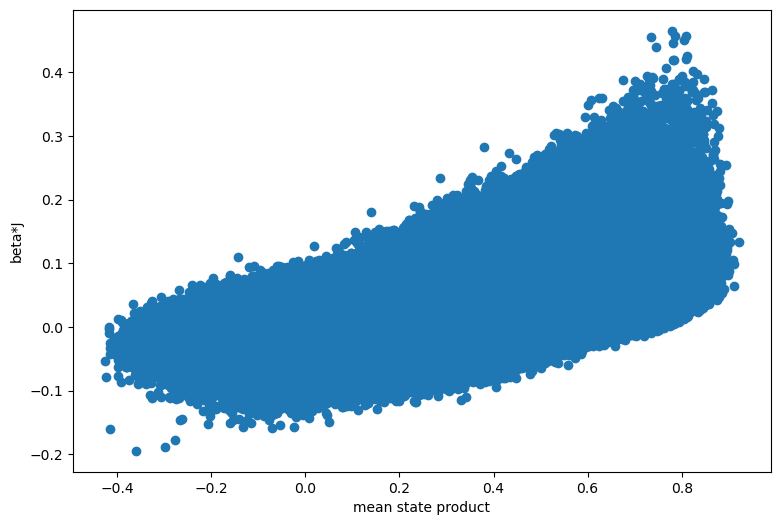

averaged over replicas
correlation between mean state product and beta*J is 0.438


In [17]:
def plot_and_print_mean_beta_J():
    mean_mean_state_product_triu = mean_state_product_triu.mean(dim=0)
    mean_beta_J_triu = beta_J_triu.mean(dim=0)
    make_scatter('mean state product', mean_mean_state_product_triu, 'beta*J', mean_beta_J_triu)
    print('averaged over replicas')
    print_correlation('mean state product', mean_mean_state_product_triu, 'beta*J', mean_beta_J_triu)
plot_and_print_mean_beta_J()

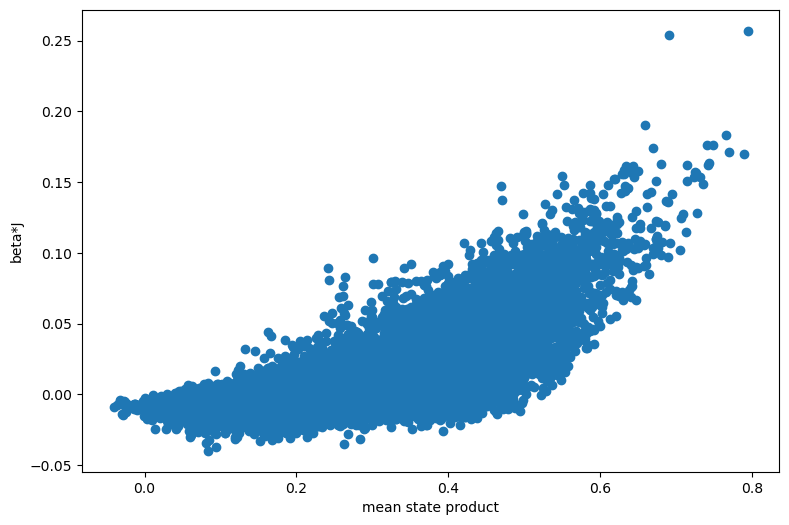

averaged over subjects
correlation between mean state product and beta*J is 0.644


In [18]:
def plot_and_print_group_beta_J():
    group_mean_state_product_triu = mean_state_product_triu.mean( dim=(0,1) )
    group_beta_J_triu = beta_J_triu.mean( dim=(0,1) )
    make_scatter('mean state product', group_mean_state_product_triu, 'beta*J', group_beta_J_triu)
    print('averaged over subjects')
    print_correlation('mean state product', group_mean_state_product_triu, 'beta*J', group_beta_J_triu)
plot_and_print_group_beta_J()

In [12]:
def load_J():
    _, _, J = load_model()
    return J
J = load_J()
num_reps = J.size(dim=0)

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [13]:
def load_covariance():
    
    mean_state_file = os.path.join(file_dir, f'mean_state_{data_file_name_part}.pt')
    mean_state = torch.load(mean_state_file)[:,training_index_start:training_index_end,:]
    print( 'mean_state size', mean_state.size() )
    mean_state = mean_state.mean(dim=0, keepdim=True)
    
    mean_state_product_file = os.path.join(file_dir, f'mean_state_product_{data_file_name_part}.pt')
    mean_state_product = torch.load(mean_state_product_file)[:,training_index_start:training_index_end,:,:]
    print( 'mean_state_porduct size', mean_state_product.size() )
    mean_state_product = mean_state_product.mean(dim=0, keepdim=True)
    
    covariance =  mean_state_product - mean_state.unsqueeze(dim=-1) * mean_state.unsqueeze(dim=-2)
    
    return covariance.repeat( (num_reps,1,1,1) )

covariance = load_covariance()

mean_state size torch.Size([4, 670, 360])
mean_state_porduct size torch.Size([4, 670, 360, 360])


In [14]:
triu_indices = torch.triu_indices( row=covariance.size(dim=-2), col=covariance.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
covariance_triu = covariance[:,:,triu_rows,triu_cols]
J_triu = J[:,:,triu_rows,triu_cols]

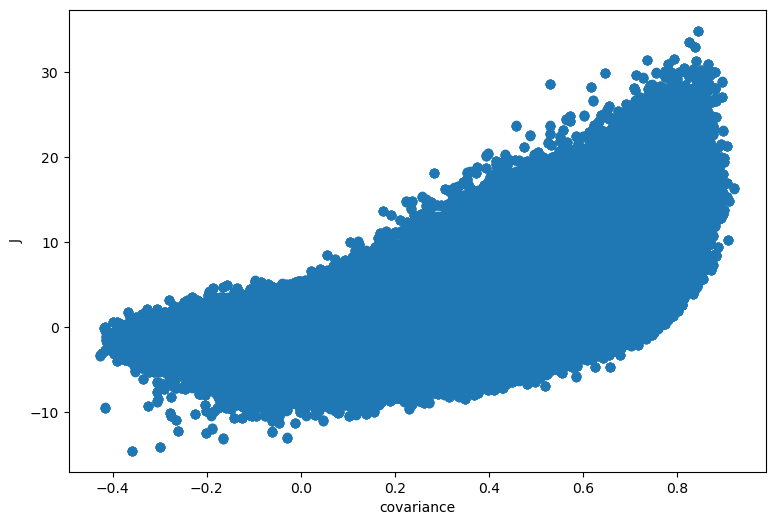

correlation between covariance and J is 0.463


tensor(0.4629, device='cuda:0')

In [15]:
make_scatter('covariance', covariance_triu, 'J', J_triu)
print_correlation('covariance', covariance_triu, 'J', J_triu)

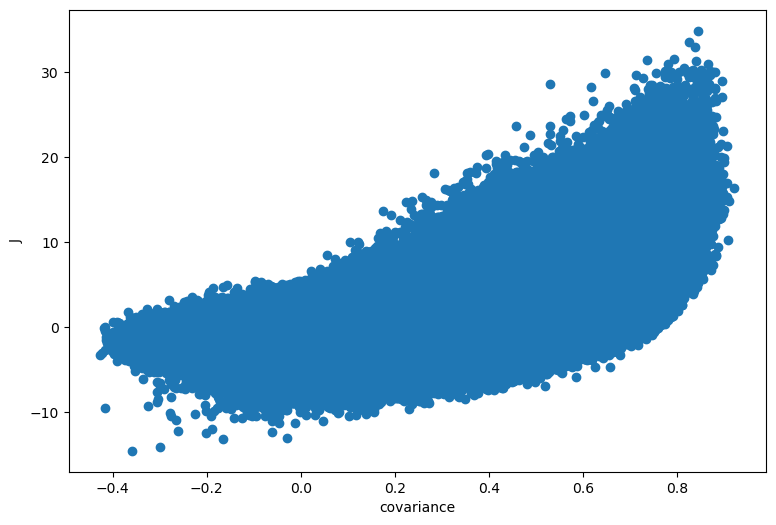

averaged over replicas
correlation between covariance and J is 0.463


In [16]:
def plot_and_print_mean_J_cov():
    mean_covariance_triu = covariance_triu.mean(dim=0)
    mean_J_triu = J_triu.mean(dim=0)
    make_scatter('covariance', mean_covariance_triu, 'J', mean_J_triu)
    print('averaged over replicas')
    print_correlation('covariance', mean_covariance_triu, 'J', mean_J_triu)
plot_and_print_mean_J_cov()

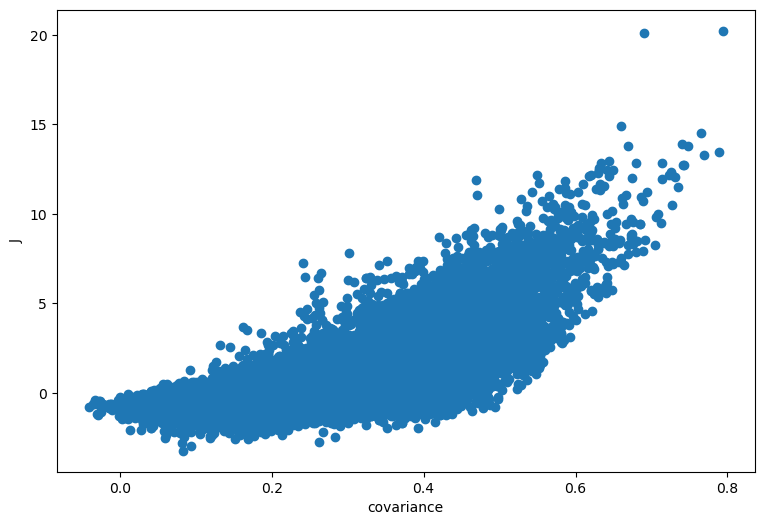

averaged over subjects
correlation between covariance and J is 0.651


In [17]:
def plot_and_print_group_J_cov():
    group_covariance_triu = covariance_triu.mean( dim=(0,1) )
    group_J_triu = J_triu.mean( dim=(0,1) )
    make_scatter('covariance', group_covariance_triu, 'J', group_J_triu)
    print('averaged over subjects')
    print_correlation('covariance', group_covariance_triu, 'J', group_J_triu)
plot_and_print_group_J_cov()

In [12]:
def load_beta_J():
    beta, _, J = load_model()
    return beta.unsqueeze(dim=-1).unsqueeze(dim=-1) * J
beta_J = load_beta_J()
num_reps = beta_J.size(dim=0)

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [14]:
triu_indices = torch.triu_indices( row=covariance.size(dim=-2), col=covariance.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
covariance_triu = covariance[:,:,triu_rows,triu_cols]
beta_J_triu = beta_J[:,:,triu_rows,triu_cols]

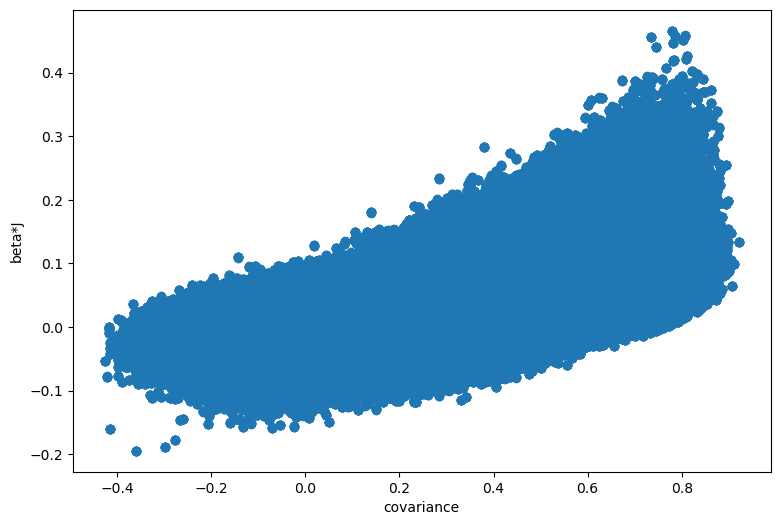

correlation between covariance and beta*J is 0.438


tensor(0.4380, device='cuda:0')

In [15]:
make_scatter('covariance', covariance_triu, 'beta*J', beta_J_triu)
print_correlation('covariance', covariance_triu, 'beta*J', beta_J_triu)

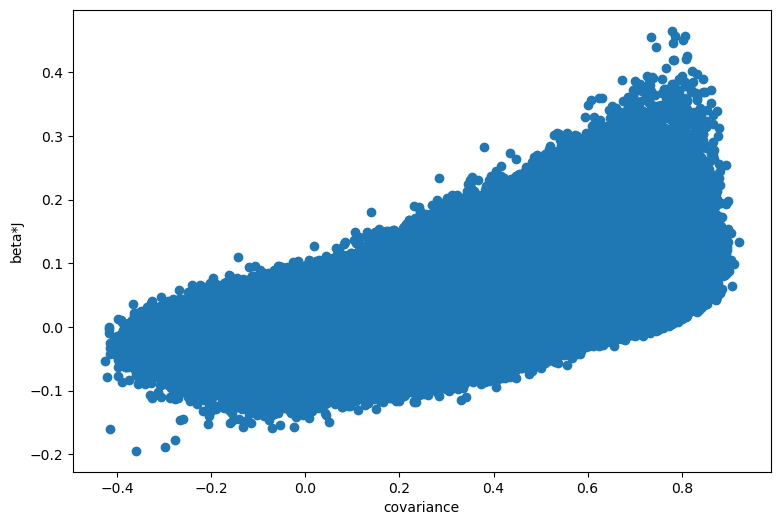

averaged over replicas
correlation between covariance and beta*J is 0.438


In [16]:
def plot_and_print_mean_beta_J_cov():
    mean_covariance_triu = covariance_triu.mean(dim=0)
    mean_beta_J_triu = beta_J_triu.mean(dim=0)
    make_scatter('covariance', mean_covariance_triu, 'beta*J', mean_beta_J_triu)
    print('averaged over replicas')
    print_correlation('covariance', mean_covariance_triu, 'beta*J', mean_beta_J_triu)
plot_and_print_mean_beta_J_cov()

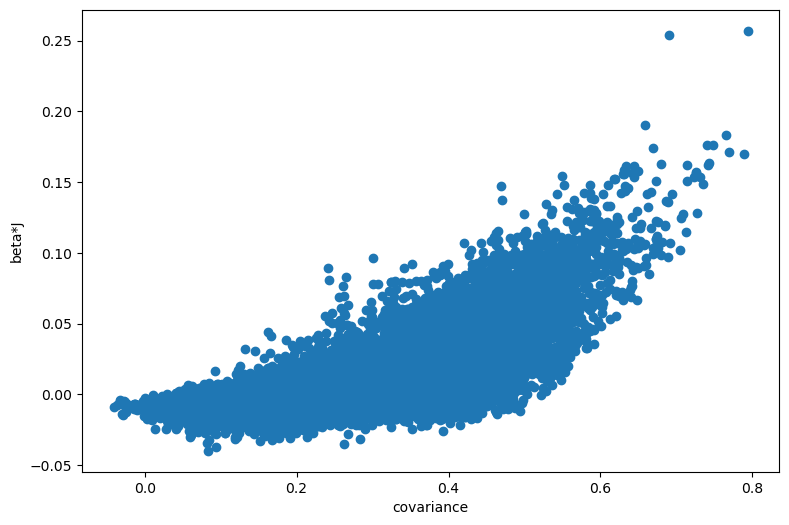

averaged over subjects
correlation between covariance and beta*J is 0.644


In [17]:
def plot_and_print_group_beta_J_cov():
    group_covariance_triu = covariance_triu.mean( dim=(0,1) )
    group_beta_J_triu = beta_J_triu.mean( dim=(0,1) )
    make_scatter('covariance', group_covariance_triu, 'beta*J', group_beta_J_triu)
    print('averaged over subjects')
    print_correlation('covariance', group_covariance_triu, 'beta*J', group_beta_J_triu)
plot_and_print_group_beta_J_cov()

In [12]:
def load_J():
    _, _, J = load_model()
    return J
J = load_J()
num_reps = J.size(dim=0)

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [14]:
def load_inv_covariance():
    
    mean_state_file = os.path.join(file_dir, f'mean_state_{data_file_name_part}.pt')
    mean_state = torch.load(mean_state_file)[:,training_index_start:training_index_end,:]
    print( 'mean_state size', mean_state.size() )
    mean_state = mean_state.mean(dim=0)
    
    mean_state_product_file = os.path.join(file_dir, f'mean_state_product_{data_file_name_part}.pt')
    mean_state_product = torch.load(mean_state_product_file)[:,training_index_start:training_index_end,:,:]
    print( 'mean_state_porduct size', mean_state_product.size() )
    mean_state_product = mean_state_product.mean(dim=0)
    
    inv_covariance = torch.linalg.inv( mean_state_product - mean_state.unsqueeze(dim=-1) * mean_state.unsqueeze(dim=-2) )
    
    return inv_covariance.unsqueeze(dim=0).repeat( (num_reps,1,1,1) )

inv_covariance = load_inv_covariance()

mean_state size torch.Size([4, 670, 360])
mean_state_porduct size torch.Size([4, 670, 360, 360])


In [14]:
triu_indices = torch.triu_indices( row=inv_covariance.size(dim=-2), col=inv_covariance.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
inv_covariance_triu = inv_covariance[:,:,triu_rows,triu_cols]
J_triu = J[:,:,triu_rows,triu_cols]

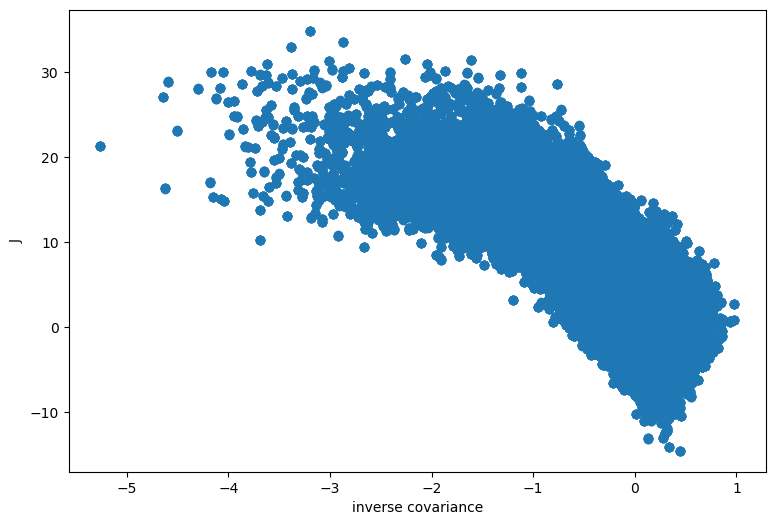

correlation between inverse covariance and J is -0.718


tensor(-0.7183, device='cuda:0')

In [15]:
make_scatter('inverse covariance', inv_covariance_triu, 'J', J_triu)
print_correlation('inverse covariance', inv_covariance_triu, 'J', J_triu)

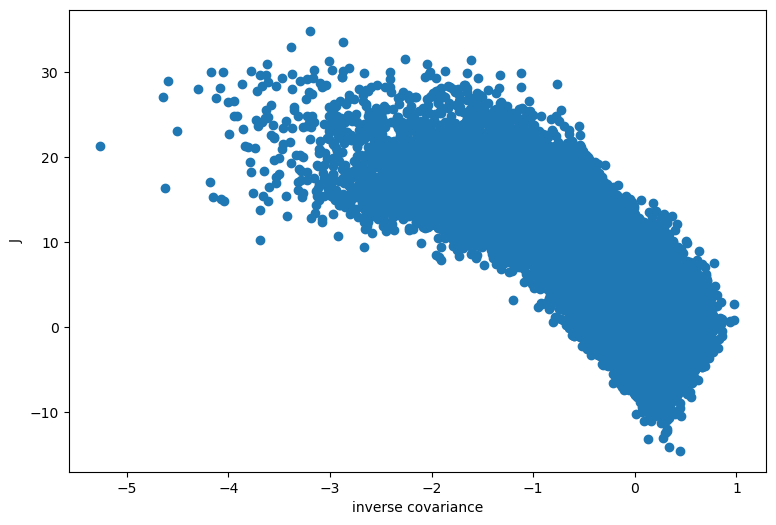

averaged over replicas
correlation between inverse covariance and J is -0.718


In [16]:
def plot_and_print_mean_J_inv_cov():
    mean_inv_covariance_triu = inv_covariance_triu.mean(dim=0)
    mean_J_triu = J_triu.mean(dim=0)
    make_scatter('inverse covariance', mean_inv_covariance_triu, 'J', mean_J_triu)
    print('averaged over replicas')
    print_correlation('inverse covariance', mean_inv_covariance_triu, 'J', mean_J_triu)
plot_and_print_mean_J_inv_cov()

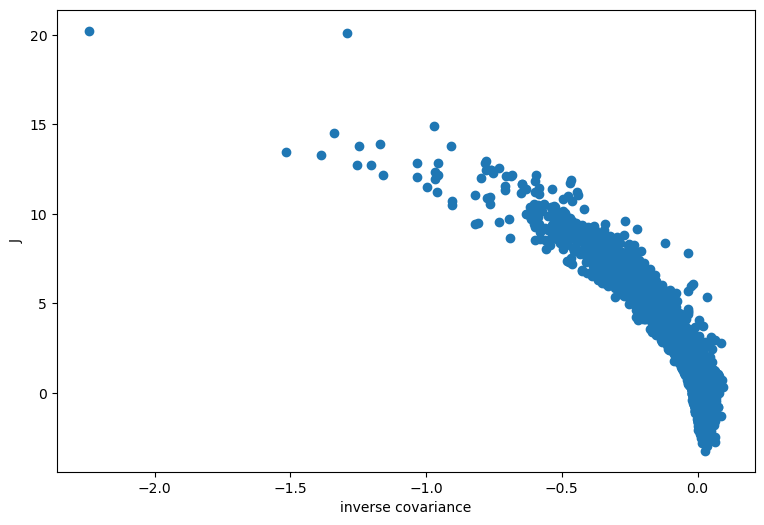

averaged over subjects
correlation between inverse covariance and J is -0.878


In [17]:
def plot_and_print_group_J_inv_cov():
    group_inv_covariance_triu = inv_covariance_triu.mean( dim=(0,1) )
    group_J_triu = J_triu.mean( dim=(0,1) )
    make_scatter('inverse covariance', group_inv_covariance_triu, 'J', group_J_triu)
    print('averaged over subjects')
    print_correlation('inverse covariance', group_inv_covariance_triu, 'J', group_J_triu)
plot_and_print_group_J_inv_cov()

In [13]:
def load_beta_J():
    beta, _, J = load_model()
    return beta.unsqueeze(dim=-1).unsqueeze(dim=-1) * J
beta_J = load_beta_J()
num_reps = beta_J.size(dim=0)

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [15]:
triu_indices = torch.triu_indices( row=inv_covariance.size(dim=-2), col=inv_covariance.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
inv_covariance_triu = inv_covariance[:,:,triu_rows,triu_cols]
beta_J_triu = beta_J[:,:,triu_rows,triu_cols]

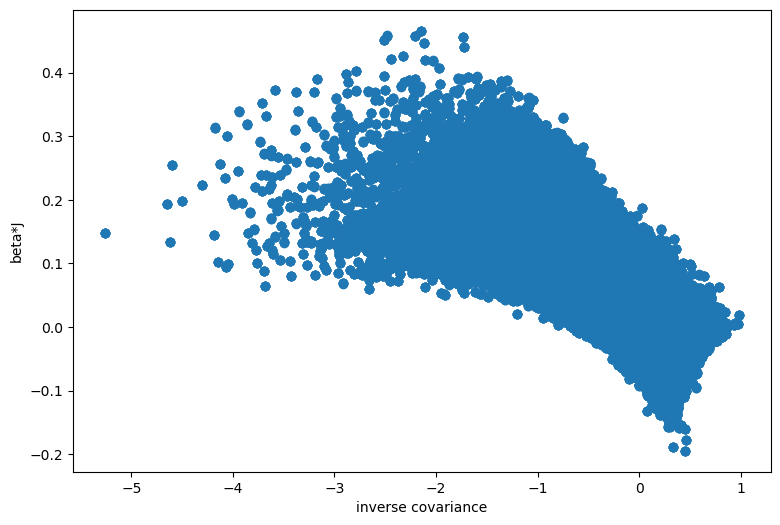

correlation between inverse covariance and beta*J is -0.71


tensor(-0.7102, device='cuda:0')

In [16]:
make_scatter('inverse covariance', inv_covariance_triu, 'beta*J', beta_J_triu)
print_correlation('inverse covariance', inv_covariance_triu, 'beta*J', beta_J_triu)

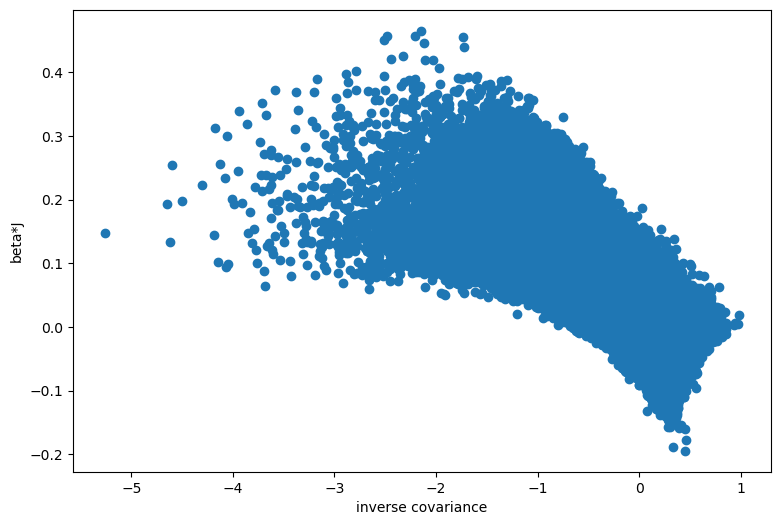

averaged over replicas
correlation between inverse covariance and beta*J is -0.71


In [17]:
def plot_and_print_mean_beta_J_inv_cov():
    mean_inv_covariance_triu = inv_covariance_triu.mean(dim=0)
    mean_beta_J_triu = beta_J_triu.mean(dim=0)
    make_scatter('inverse covariance', mean_inv_covariance_triu, 'beta*J', mean_beta_J_triu)
    print('averaged over replicas')
    print_correlation('inverse covariance', mean_inv_covariance_triu, 'beta*J', mean_beta_J_triu)
plot_and_print_mean_beta_J_inv_cov()

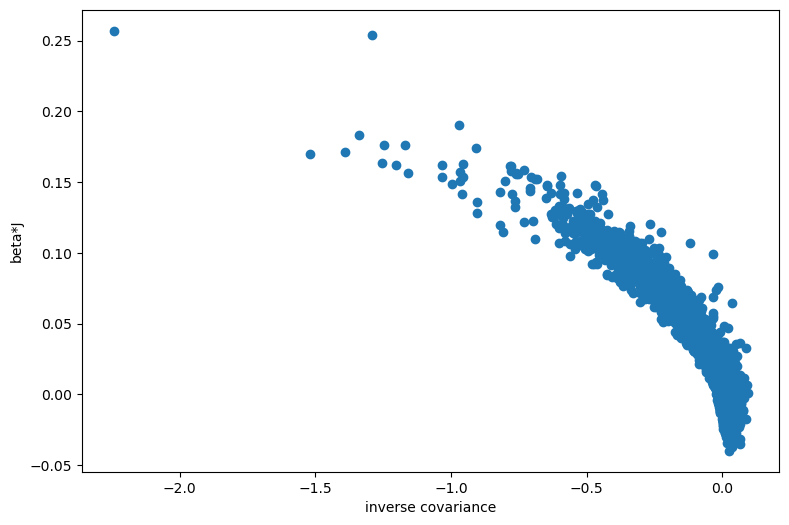

averaged over subjects
correlation between inverse covariance and beta*J is -0.886


In [18]:
def plot_and_print_group_beta_J_cov():
    group_inv_covariance_triu = inv_covariance_triu.mean( dim=(0,1) )
    group_beta_J_triu = beta_J_triu.mean( dim=(0,1) )
    make_scatter('inverse covariance', group_inv_covariance_triu, 'beta*J', group_beta_J_triu)
    print('averaged over subjects')
    print_correlation('inverse covariance', group_inv_covariance_triu, 'beta*J', group_beta_J_triu)
plot_and_print_group_beta_J_cov()

In [12]:
def load_J():
    _, _, J = load_model()
    return J
J = load_J()
num_reps = J.size(dim=0)

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [14]:
def load_fc():
    
    mean_state_file = os.path.join(file_dir, f'mean_state_{data_file_name_part}.pt')
    mean_state = torch.load(mean_state_file)[:,training_index_start:training_index_end,:]
    print( 'mean_state size', mean_state.size() )
    mean_state = mean_state.mean(dim=0, keepdim=True)
    
    mean_state_product_file = os.path.join(file_dir, f'mean_state_product_{data_file_name_part}.pt')
    mean_state_product = torch.load(mean_state_product_file)[:,training_index_start:training_index_end,:,:]
    print( 'mean_state_porduct size', mean_state_product.size() )
    mean_state_product = mean_state_product.mean(dim=0, keepdim=True)
    
    std_dev = torch.sqrt(1 - mean_state*mean_state)
    fc =  ( mean_state_product - mean_state.unsqueeze(dim=-1) * mean_state.unsqueeze(dim=-2) )/( std_dev.unsqueeze(dim=-1) * std_dev.unsqueeze(dim=-2) )
    
    return fc.repeat( (num_reps,1,1,1) )

fc = load_fc()

mean_state size torch.Size([4, 670, 360])
mean_state_porduct size torch.Size([4, 670, 360, 360])


In [14]:
triu_indices = torch.triu_indices( row=fc.size(dim=-2), col=fc.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
fc_triu = fc[:,:,triu_rows,triu_cols]
J_triu = J[:,:,triu_rows,triu_cols]

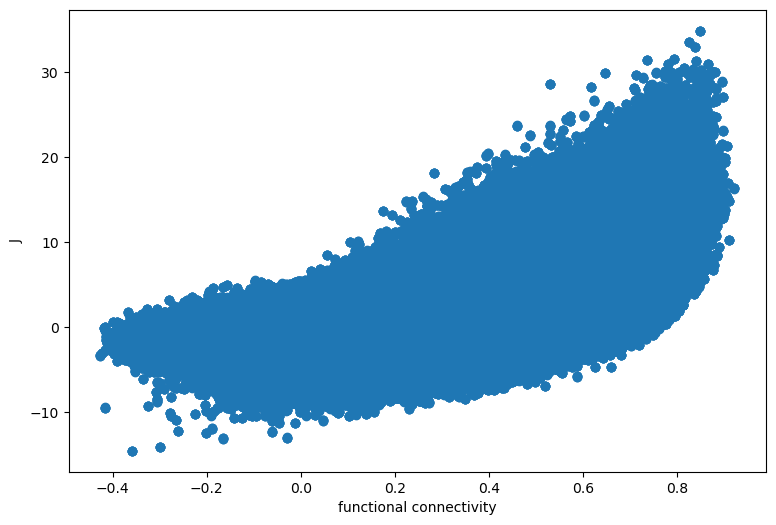

correlation between functional connectivity and J is 0.463


tensor(0.4629, device='cuda:0')

In [15]:
make_scatter('functional connectivity', fc_triu, 'J', J_triu)
print_correlation('functional connectivity', fc_triu, 'J', J_triu)

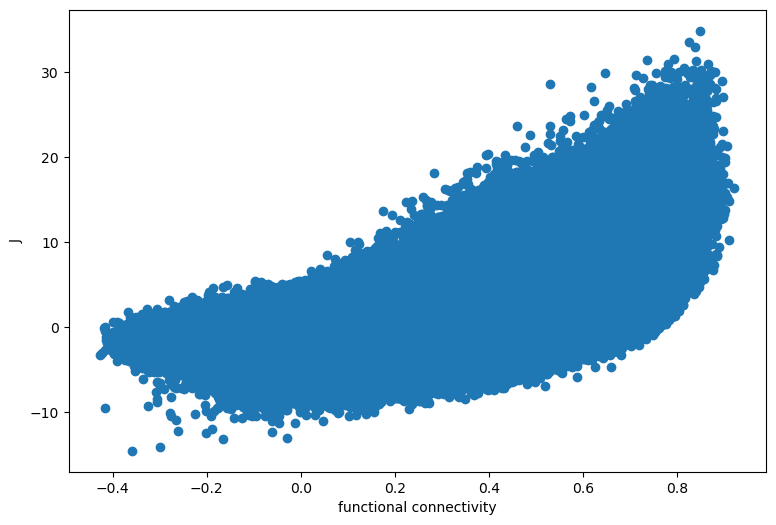

averaged over replicas
correlation between functional connectivity and J is 0.463


In [16]:
def plot_and_print_mean_J_fc():
    mean_fc_triu = fc_triu.mean(dim=0)
    mean_J_triu = J_triu.mean(dim=0)
    make_scatter('functional connectivity', mean_fc_triu, 'J', mean_J_triu)
    print('averaged over replicas')
    print_correlation('functional connectivity', mean_fc_triu, 'J', mean_J_triu)
plot_and_print_mean_J_fc()

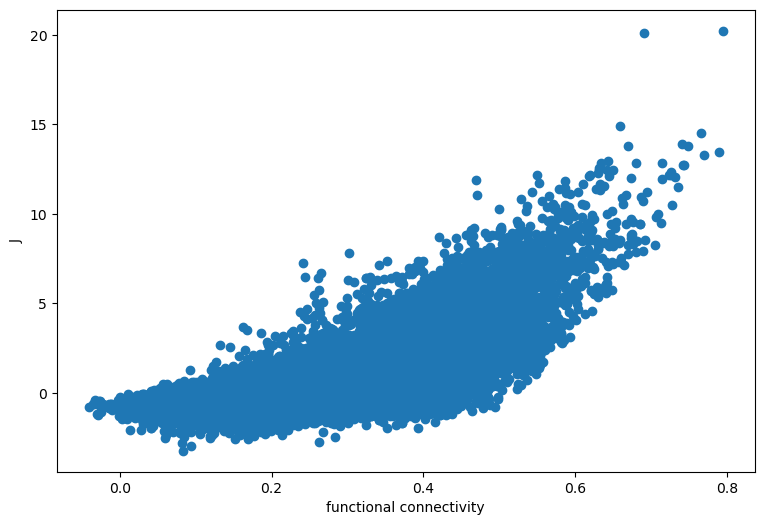

averaged over subjects
correlation between functional connectivity and J is 0.651


In [17]:
def plot_and_print_group_J_fc():
    group_fc_triu = fc_triu.mean( dim=(0,1) )
    group_J_triu = J_triu.mean( dim=(0,1) )
    make_scatter('functional connectivity', group_fc_triu, 'J', group_J_triu)
    print('averaged over subjects')
    print_correlation('functional connectivity', group_fc_triu, 'J', group_J_triu)
plot_and_print_group_J_fc()

In [13]:
def load_beta_J():
    beta, _, J = load_model()
    return beta.unsqueeze(dim=-1).unsqueeze(dim=-1) * J
beta_J = load_beta_J()
num_reps = beta_J.size(dim=0)

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [15]:
triu_indices = torch.triu_indices( row=fc.size(dim=-2), col=fc.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
fc_triu = fc[:,:,triu_rows,triu_cols]
beta_J_triu = beta_J[:,:,triu_rows,triu_cols]

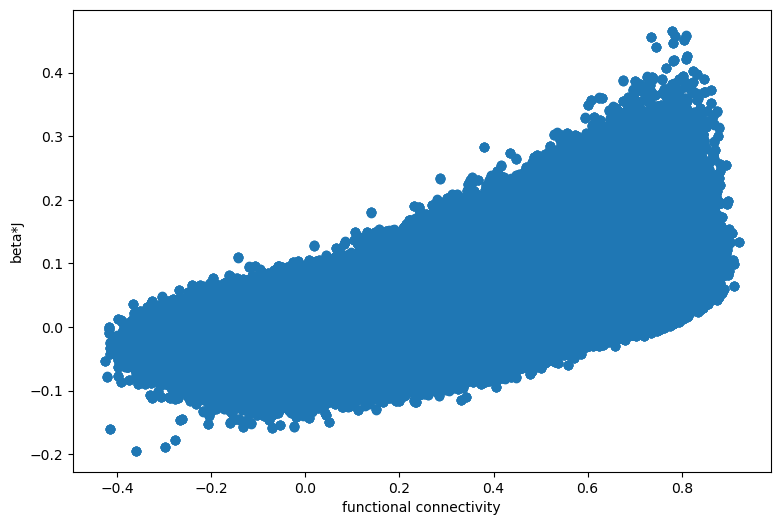

correlation between functional connectivity and beta*J is 0.438


tensor(0.4380, device='cuda:0')

In [16]:
make_scatter('functional connectivity', fc_triu, 'beta*J', beta_J_triu)
print_correlation('functional connectivity', fc_triu, 'beta*J', beta_J_triu)

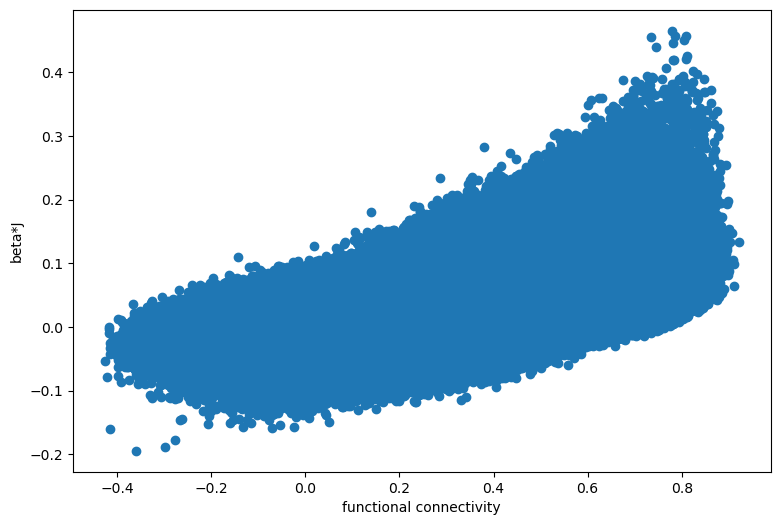

averaged over replicas
correlation between functional connectivity and beta*J is 0.438


In [17]:
def plot_and_print_mean_beta_J_fc():
    mean_fc_triu = fc_triu.mean(dim=0)
    mean_beta_J_triu = beta_J_triu.mean(dim=0)
    make_scatter('functional connectivity', mean_fc_triu, 'beta*J', mean_beta_J_triu)
    print('averaged over replicas')
    print_correlation('functional connectivity', mean_fc_triu, 'beta*J', mean_beta_J_triu)
plot_and_print_mean_beta_J_fc()

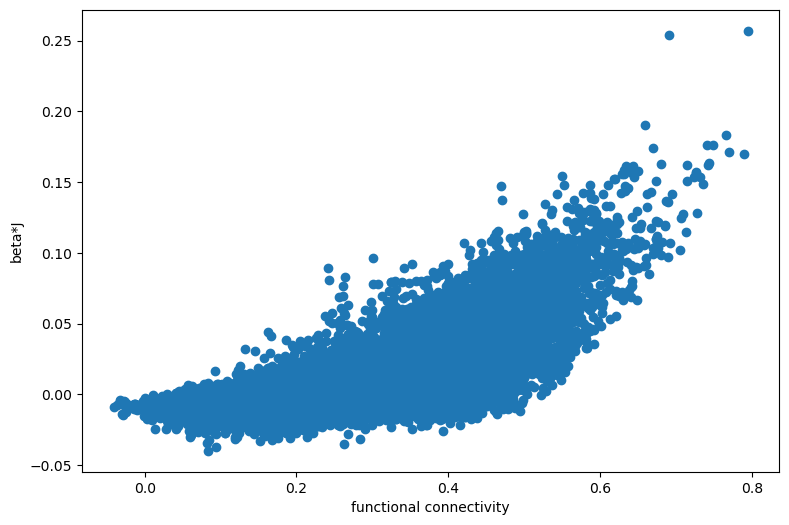

averaged over subjects
correlation between functional connectivity and beta*J is 0.644


In [18]:
def plot_and_print_group_beta_J_fc():
    group_fc_triu = fc_triu.mean( dim=(0,1) )
    group_beta_J_triu = beta_J_triu.mean( dim=(0,1) )
    make_scatter('functional connectivity', group_fc_triu, 'beta*J', group_beta_J_triu)
    print('averaged over subjects')
    print_correlation('functional connectivity', group_fc_triu, 'beta*J', group_beta_J_triu)
plot_and_print_group_beta_J_fc()

In [12]:
def load_J():
    _, _, J = load_model()
    return J
J = load_J()
num_reps = J.size(dim=0)

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [14]:
def load_inv_fc():
    
    mean_state_file = os.path.join(file_dir, f'mean_state_{data_file_name_part}.pt')
    mean_state = torch.load(mean_state_file)[:,training_index_start:training_index_end,:]
    print( 'mean_state size', mean_state.size() )
    mean_state = mean_state.mean(dim=0, keepdim=True)
    
    mean_state_product_file = os.path.join(file_dir, f'mean_state_product_{data_file_name_part}.pt')
    mean_state_product = torch.load(mean_state_product_file)[:,training_index_start:training_index_end,:,:]
    print( 'mean_state_product size', mean_state_product.size() )
    mean_state_product = mean_state_product.mean(dim=0, keepdim=True)
    
    std_dev = torch.sqrt(1 - mean_state*mean_state)
    inv_fc =  torch.linalg.inv(  ( mean_state_product - mean_state.unsqueeze(dim=-1) * mean_state.unsqueeze(dim=-2) )/( std_dev.unsqueeze(dim=-1) * std_dev.unsqueeze(dim=-2) )  )
    
    return inv_fc.repeat( (num_reps,1,1,1) )

inv_fc = load_inv_fc()

mean_state size torch.Size([4, 670, 360])
mean_state_product size torch.Size([4, 670, 360, 360])


In [14]:
triu_indices = torch.triu_indices( row=inv_fc.size(dim=-2), col=inv_fc.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
inv_fc_triu = inv_fc[:,:,triu_rows,triu_cols]
J_triu = J[:,:,triu_rows,triu_cols]

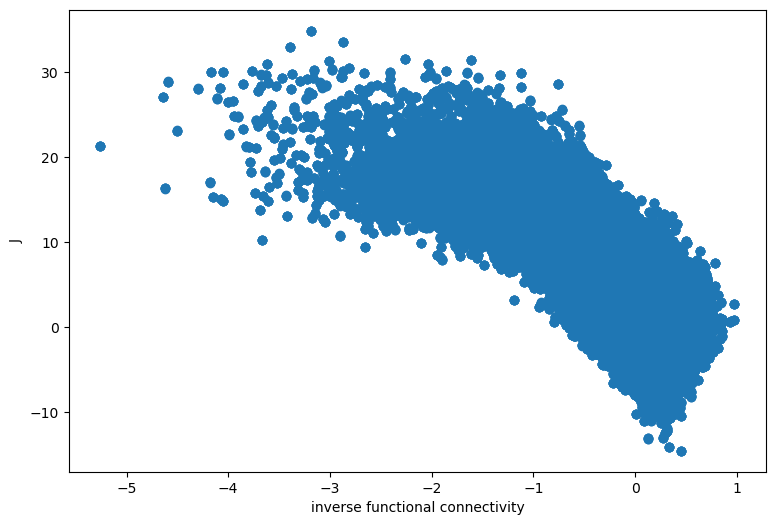

correlation between inverse functional connectivity and J is -0.718


tensor(-0.7183, device='cuda:0')

In [15]:
make_scatter('inverse functional connectivity', inv_fc_triu, 'J', J_triu)
print_correlation('inverse functional connectivity', inv_fc_triu, 'J', J_triu)

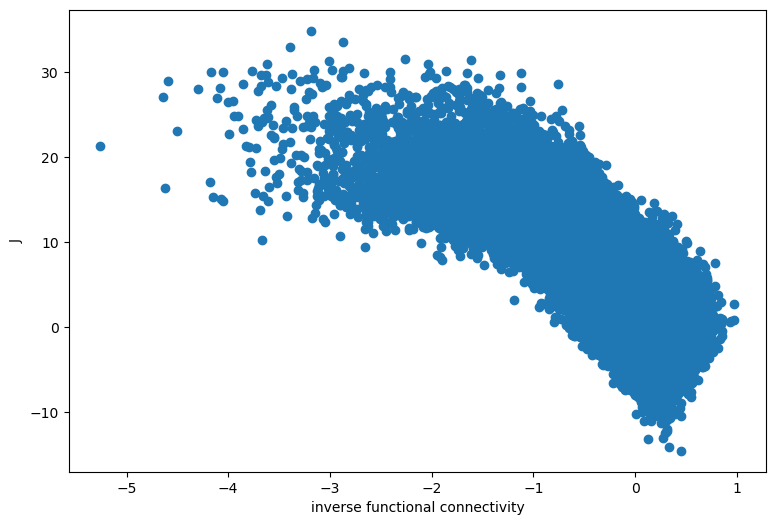

averaged over replicas
correlation between inverse functional connectivity and J is -0.718


In [16]:
def plot_and_print_mean_J_inv_fc():
    mean_inv_fc_triu = inv_fc_triu.mean(dim=0)
    mean_J_triu = J_triu.mean(dim=0)
    make_scatter('inverse functional connectivity', mean_inv_fc_triu, 'J', mean_J_triu)
    print('averaged over replicas')
    print_correlation('inverse functional connectivity', mean_inv_fc_triu, 'J', mean_J_triu)
plot_and_print_mean_J_inv_fc()

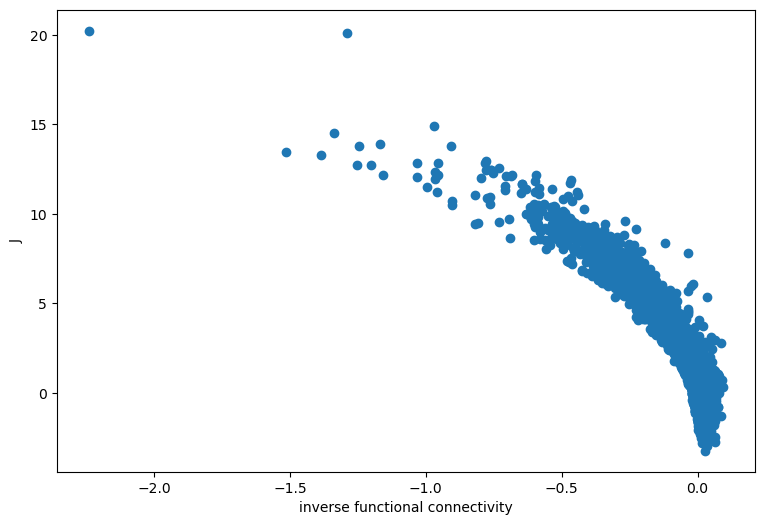

averaged over subjects
correlation between inverse functional connectivity and J is -0.878


In [17]:
def plot_and_print_group_J_inv_fc():
    group_inv_fc_triu = inv_fc_triu.mean( dim=(0,1) )
    group_J_triu = J_triu.mean( dim=(0,1) )
    make_scatter('inverse functional connectivity', group_inv_fc_triu, 'J', group_J_triu)
    print('averaged over subjects')
    print_correlation('inverse functional connectivity', group_inv_fc_triu, 'J', group_J_triu)
plot_and_print_group_J_inv_fc()

In [13]:
def load_beta_J():
    beta, _, J = load_model()
    return beta.unsqueeze(dim=-1).unsqueeze(dim=-1) * J
beta_J = load_beta_J()
num_reps = beta_J.size(dim=0)

loaded E:\Ising_model_results_daai\ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt
beta size torch.Size([5, 837])
h size torch.Size([5, 837, 360])
J size torch.Size([5, 837, 360, 360])
beta with just training subjects size torch.Size([5, 670])
h with just training subjects size torch.Size([5, 670, 360])
J with just training subjects size torch.Size([5, 670, 360, 360])


In [15]:
triu_indices = torch.triu_indices( row=inv_fc.size(dim=-2), col=inv_fc.size(dim=-1), offset=1 )
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
inv_fc_triu = inv_fc[:,:,triu_rows,triu_cols]
beta_J_triu = beta_J[:,:,triu_rows,triu_cols]

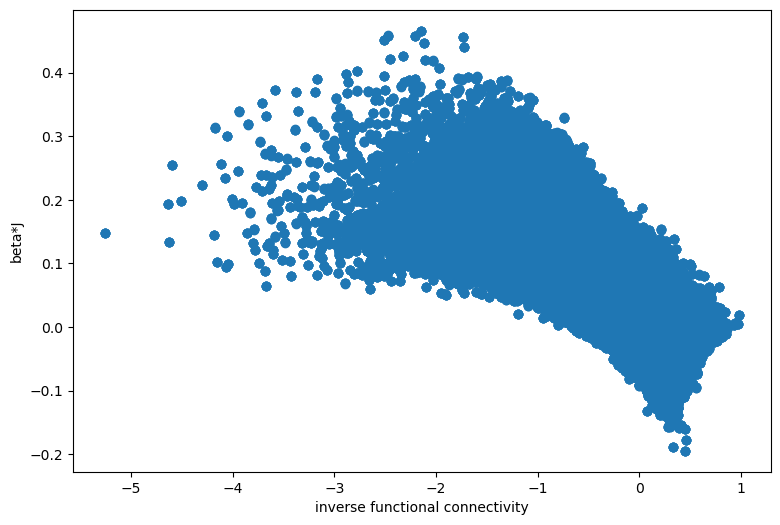

correlation between inverse functional connectivity and beta*J is -0.71


tensor(-0.7102, device='cuda:0')

In [16]:
make_scatter('inverse functional connectivity', inv_fc_triu, 'beta*J', beta_J_triu)
print_correlation('inverse functional connectivity', inv_fc_triu, 'beta*J', beta_J_triu)

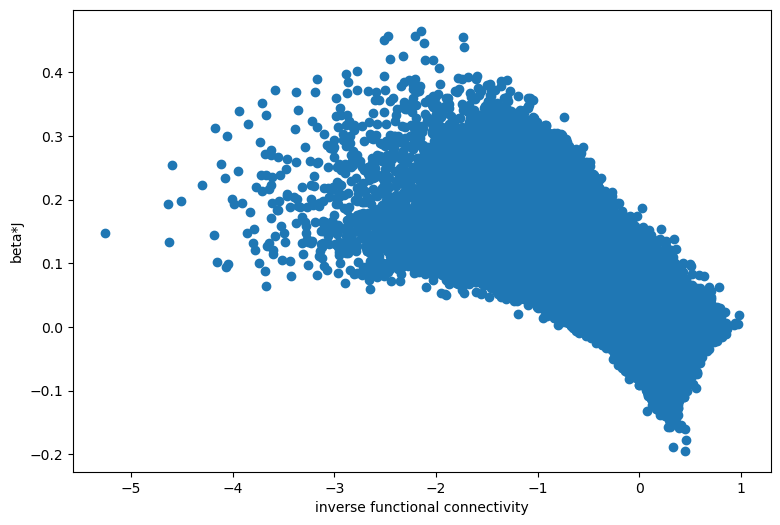

averaged over replicas
correlation between inverse functional connectivity and beta*J is -0.71


In [17]:
def plot_and_print_mean_beta_J_inv_fc():
    mean_inv_fc_triu = inv_fc_triu.mean(dim=0)
    mean_beta_J_triu = beta_J_triu.mean(dim=0)
    make_scatter('inverse functional connectivity', mean_inv_fc_triu, 'beta*J', mean_beta_J_triu)
    print('averaged over replicas')
    print_correlation('inverse functional connectivity', mean_inv_fc_triu, 'beta*J', mean_beta_J_triu)
plot_and_print_mean_beta_J_inv_fc()

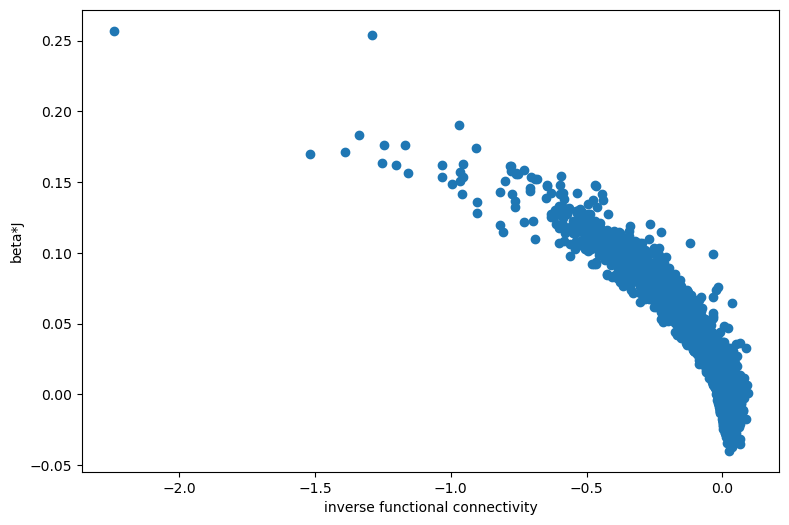

averaged over subjects
correlation between inverse functional connectivity and beta*J is -0.886


In [18]:
def plot_and_print_group_beta_J_inv_fc():
    group_inv_fc_triu = inv_fc_triu.mean( dim=(0,1) )
    group_beta_J_triu = beta_J_triu.mean( dim=(0,1) )
    make_scatter('inverse functional connectivity', group_inv_fc_triu, 'beta*J', group_beta_J_triu)
    print('averaged over subjects')
    print_correlation('inverse functional connectivity', group_inv_fc_triu, 'beta*J', group_beta_J_triu)
plot_and_print_group_beta_J_inv_fc()

In [19]:
mean_mean_state = mean_state.mean(dim=0)
mean_mean_state_product = mean_state_product.mean( dim=0 )
mean_covariance = mean_mean_state_product - mean_mean_state.unsqueeze(dim=-1) * mean_mean_state.unsqueeze(dim=-2)
mean_inv_covariance = torch.linalg.inv(mean_covariance)
mean_mean_state_product_triu = mean_mean_state_product[:,triu_rows,triu_cols]
mean_covariance_triu = mean_covariance[:,triu_rows,triu_cols]
mean_inv_covariance_triu = mean_inv_covariance[:,triu_rows,triu_cols]

In [15]:
beta_training_unsqueezed = beta_training.unsqueeze(dim=-1)
beta_h_training = beta_training_unsqueezed * h_training
beta_J_training_triu = beta_training_unsqueezed * J_training_triu

In [21]:
mean_h = h_training.mean(dim=0)
mean_J_triu = J_training_triu.mean(dim=0)
mean_beta_h = beta_h_training.mean(dim=0)
mean_beta_J_triu = beta_J_training_triu.mean(dim=0)

In [22]:
group_mean_state = mean_mean_state.mean(dim=0)
group_mean_state_product = mean_mean_state_product.mean(dim=0)
group_covariance = group_mean_state_product - group_mean_state.unsqueeze(dim=-1) * group_mean_state.unsqueeze(dim=-2)
group_inv_covariance = torch.linalg.inv(group_covariance)
group_mean_state_product_triu = group_mean_state_product[triu_rows,triu_cols]
group_covariance_triu = group_covariance[triu_rows,triu_cols]
group_inv_covariance_triu = group_inv_covariance[triu_rows,triu_cols]

In [23]:
group_h = mean_h.mean(dim=0)
group_J_triu = mean_J_triu.mean(dim=0)
group_beta_h = mean_beta_h.mean(dim=0)
group_beta_J_triu = mean_beta_J_triu.mean(dim=0)

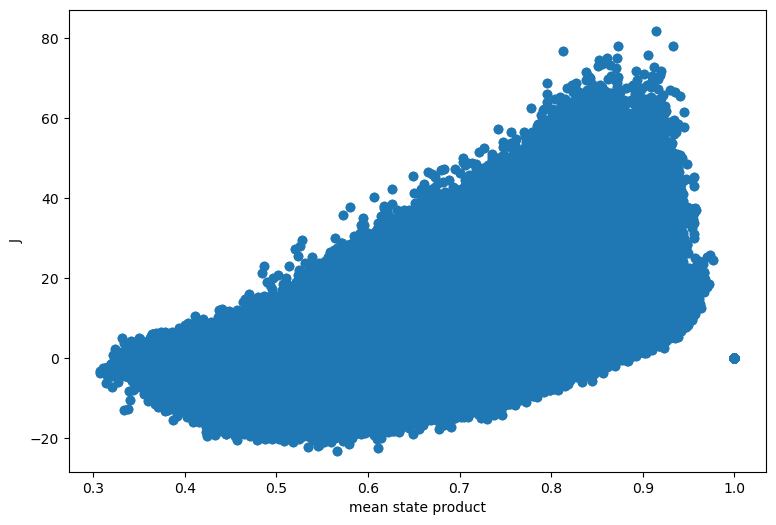

In [16]:
make_scatter('mean state product', mean_mean_state_product_triu, 'J', mean_J_triu)
print('averaged over replications')
print_correlation('mean state product', mean_mean_state_product_triu, 'J', mean_J_triu)

In [ ]:
make_scatter('mean state product', group_mean_state_product_triu, 'J', group_J_triu)
print('averaged over subjects')
print_correlation('mean state product', group_mean_state_product_triu, 'J', group_J_triu)

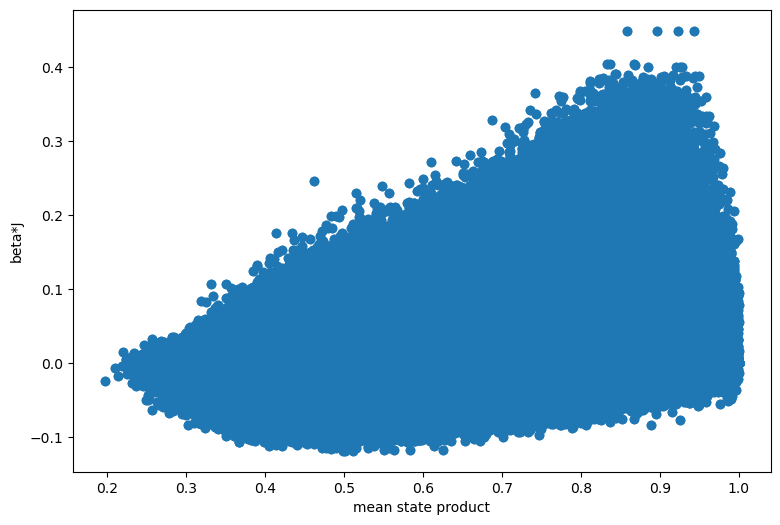

In [17]:
Jbeta = J_training * beta_training.unsqueeze(dim=-1).unsqueeze(dim=-1)
num_reps = min( mean_state_product.size(dim=0), Jbeta.size(dim=0) )
make_scatter(xname='mean state product', xvalues=mean_state_product[:num_reps,:,:,:], yname='beta*J', yvalues=Jbeta[:num_reps,:,:,:])

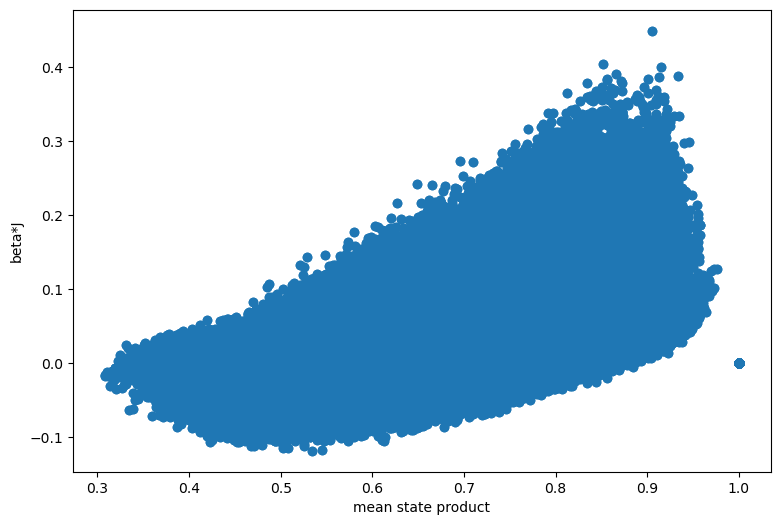

In [18]:
mean_mean_state_product = mean_state_product.mean(dim=0)
mean_Jbeta = Jbeta.mean(dim=0)
make_scatter(xname='mean state product', xvalues=mean_mean_state_product, yname='beta*J', yvalues=mean_Jbeta)

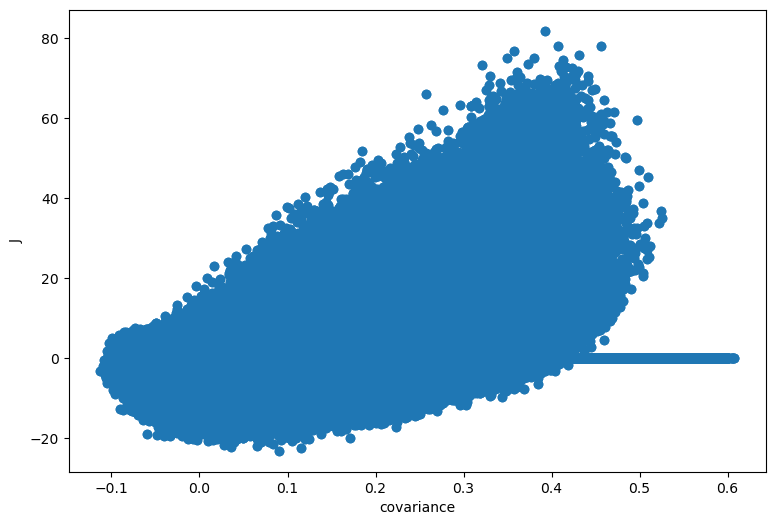

In [19]:
covariance = mean_mean_state_product - mean_mean_state.unsqueeze(dim=-1) * mean_mean_state.unsqueeze(dim=-2)
make_scatter(xname='covariance', xvalues=covariance, yname='J', yvalues=mean_J)

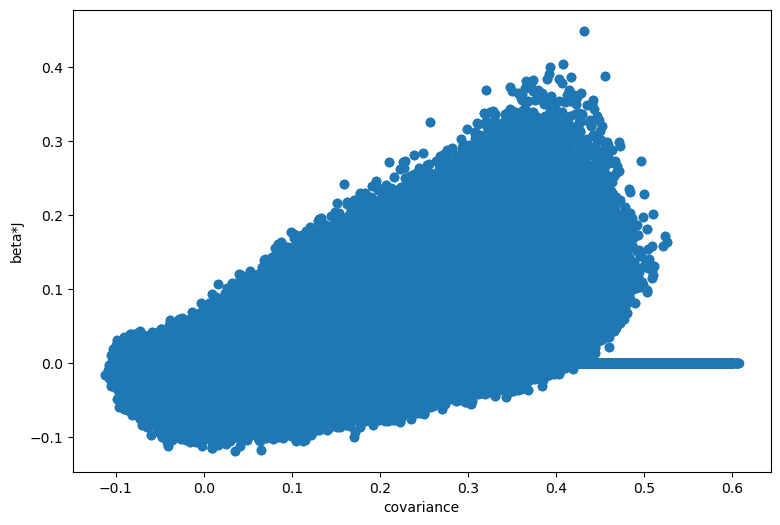

In [20]:
make_scatter(xname='covariance', xvalues=covariance, yname='beta*J', yvalues=mean_Jbeta)

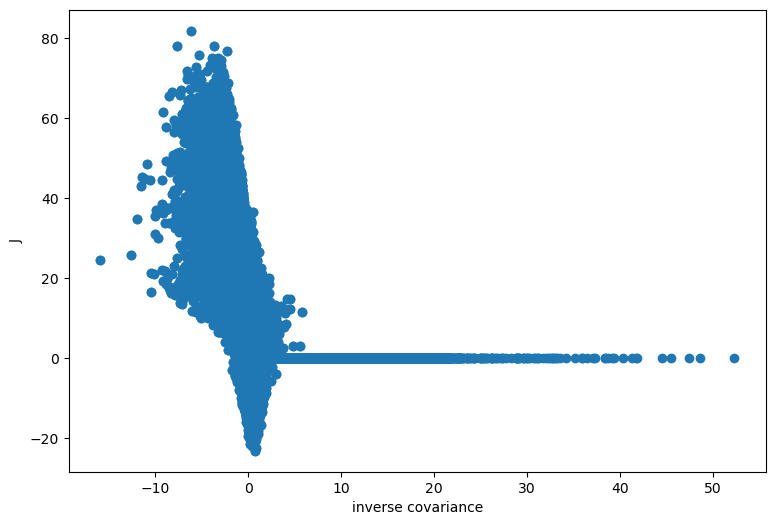

In [21]:
inv_covariance = torch.linalg.inv(covariance)
make_scatter(xname='inverse covariance', xvalues=inv_covariance, yname='J', yvalues=mean_J)

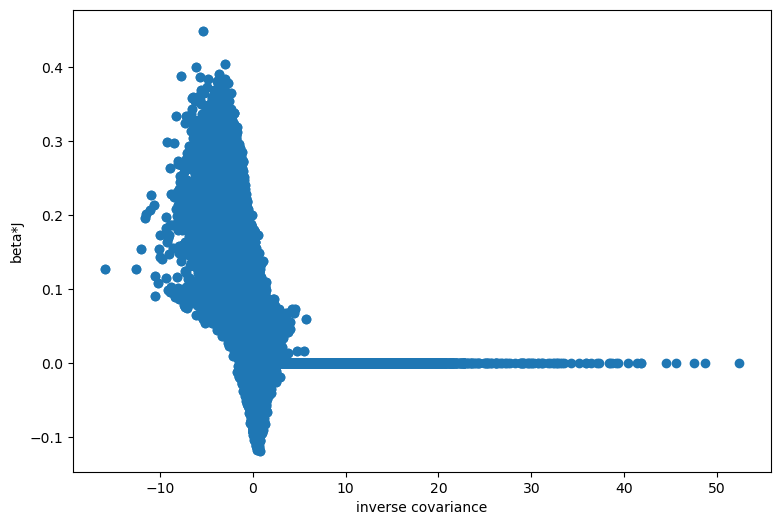

In [22]:
make_scatter(xname='inverse covariance', xvalues=inv_covariance, yname='beta*J', yvalues=mean_Jbeta)

inv_cov_triu size torch.Size([670, 64620])


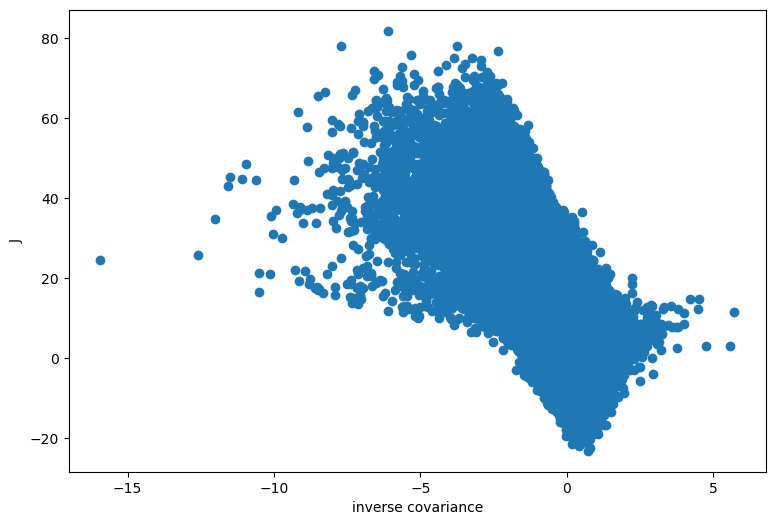

In [23]:
inv_cov_triu_indices = torch.triu_indices( row=inv_covariance.size(dim=-2), col=inv_covariance.size(dim=-1), offset=1 )
triu_rows = inv_cov_triu_indices[0]
triu_cols = inv_cov_triu_indices[1]
inv_cov_triu = inv_covariance[:,triu_rows,triu_cols]
J_triu = mean_J[:,triu_rows,triu_cols]
print( 'inv_cov_triu size', inv_cov_triu.size() )
make_scatter(xname='inverse covariance', xvalues=inv_cov_triu, yname='J', yvalues=J_triu)

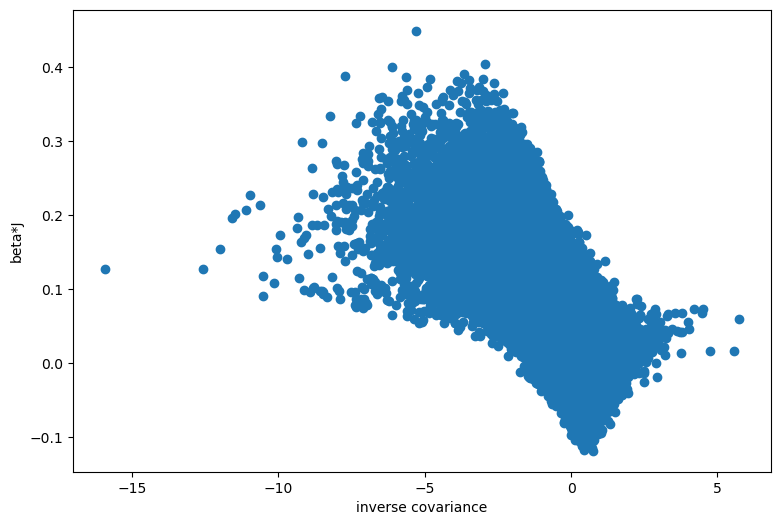

In [24]:
Jbeta_triu = mean_Jbeta[:,triu_rows,triu_cols]
make_scatter(xname='inverse covariance', xvalues=inv_cov_triu, yname='beta*J', yvalues=Jbeta_triu)